# Работа с рукописными цифрами.

## Этап 1. Познакомимся с данными.

Воспользуемся данными с https://www.kaggle.com/c/digit-recognizer/data . 
Далее размещаем файлы test.csv и train.csv в одной директории с notebook-ом.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from copy import deepcopy
%matplotlib inline
import math

Напишем функцию, которая переводит данный вектор в изображения, размера n x n.

In [30]:
def to_img(vector, demension):
    img = list([])
    j = demension
    while (j <= len(vector)):
        img.append(vector[j - demension + 1: j])
        j += demension
    return img

Загрузим обучающую выборку.

In [31]:
data = list([])
f = open("train.csv")
i = 0
for line in f:
    if i == 0:
        i = 1
        continue
    data.append(list(map(int, line.split(','))))
f.close()
data = np.array(data)
x_train = data[:, 1:]
y_train = data[:, 0]

## Этап 2. Нарисуем каждую цифру по одному разу.

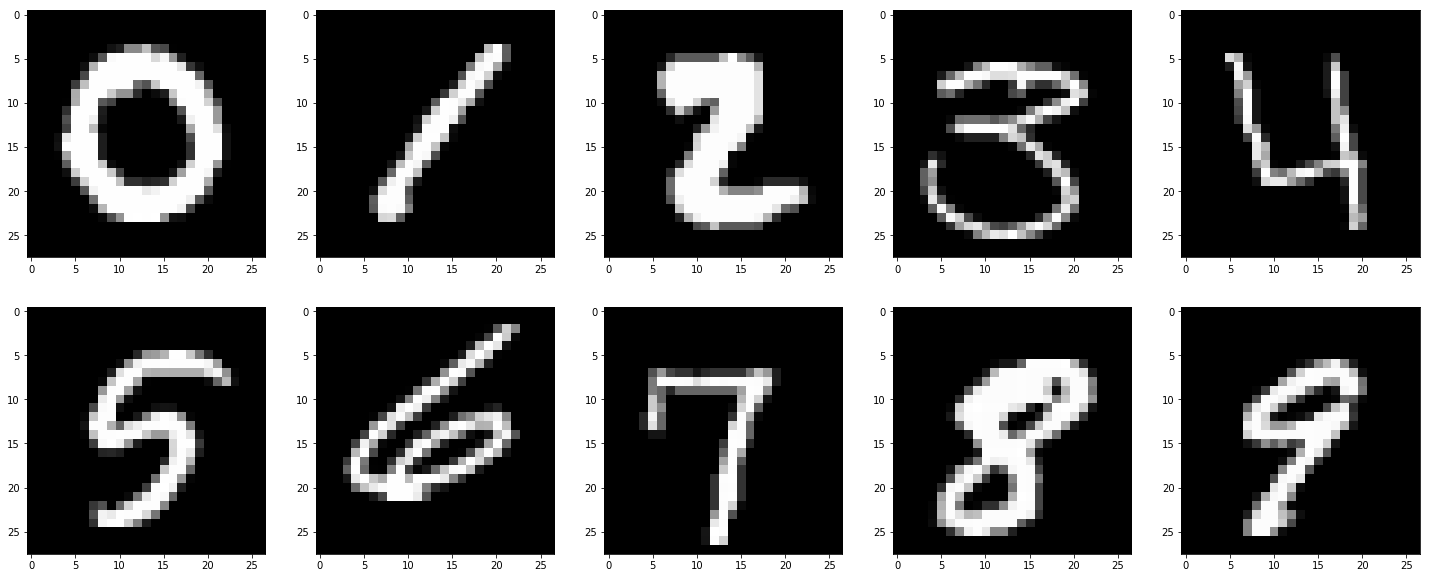

In [32]:
plt.figure(figsize=(25, 10))
for i in range(10):
    for k in range(len(x_train)):
        if y_train[k] == i:
            plt.subplot(2, 5, i + 1)
            plt.imshow(to_img(x_train[k], 28), cmap='gray')
            break


In [33]:
print(len(x_train))

42000


## Этап 3. Нарисуем среднее изображение.

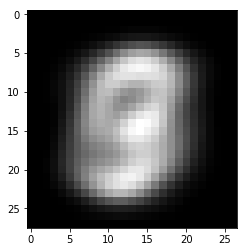

In [34]:
average_img_for_all = sum(x_train) // len(x_train)
plt.imshow(to_img(average_img_for_all, 28), cmap='gray')

## Этап 4. Нарисуем среднее изображение для каждой из цифр.
А так же запомним их в список average_images, где i-й элемент соответствует среднему рисунку для i-й цифры.

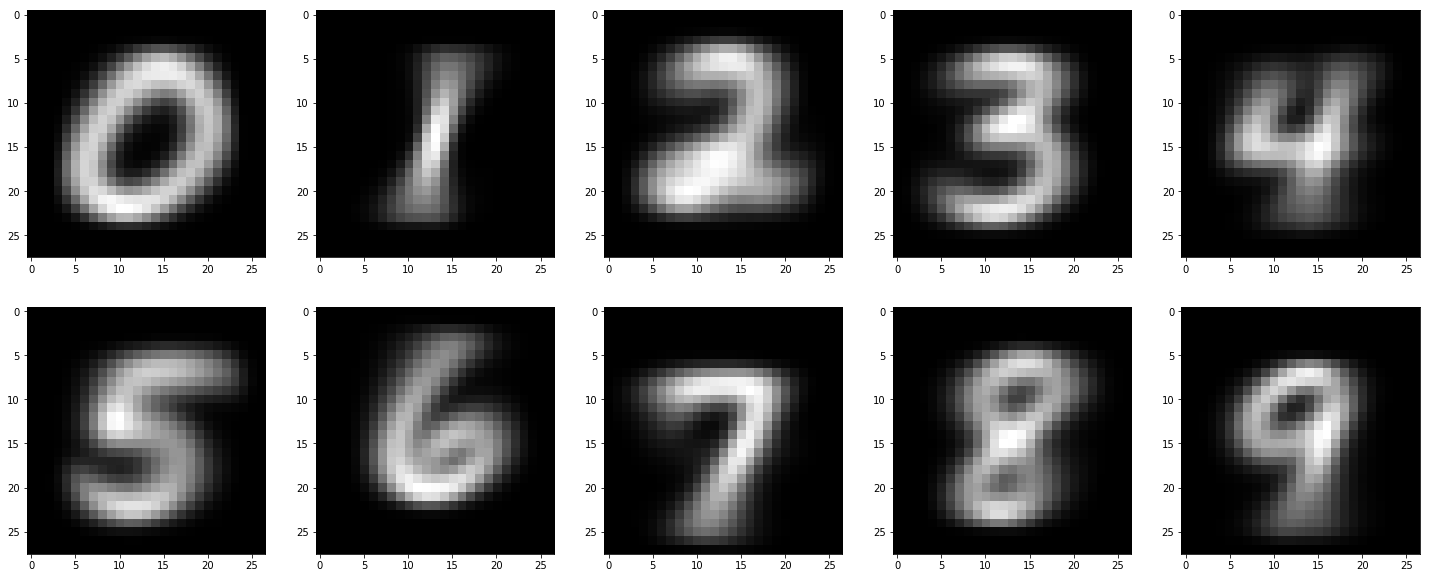

In [35]:
plt.figure(figsize=(25, 10))
average_images = np.zeros((10, len(x_train[0])), dtype=int)
for digit in range(10):
    average_img = np.array([0] * len(x_train[0]))
    k = 0
    for i in range(len(x_train)):
        if y_train[i] == digit:
            average_img += x_train[i]
            k += 1
    average_images[digit] = average_img
    plt.subplot(2, 5, digit + 1)
    plt.imshow(to_img(average_img, 28), cmap='gray')

## Этап 5. Нарисуем 3 самых близких к среднему изображиний и 3 самых далеких от среднего изображений. 
В первой строке выведем 3 самых близких, а во второй 3 самых далеких. Будем говорить, что изображение близко к среднему изображению, если разность текущего вектора, задающего картинку, и среднего минимальна. 

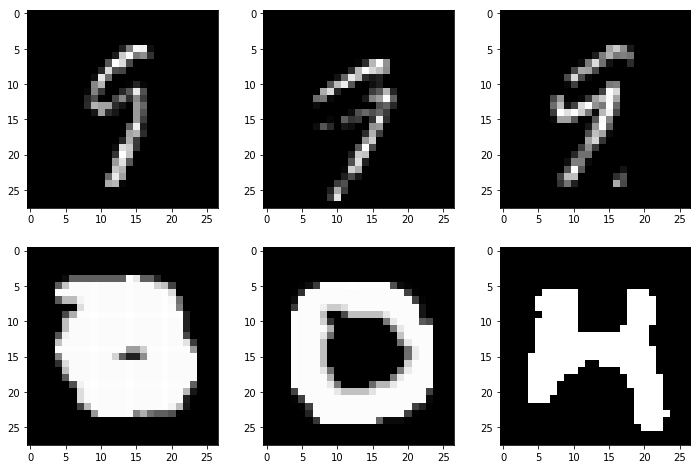

In [36]:
plt.figure(figsize=(12, 8))
min_imgs = list([])
max_imgs = list([])
for i in range(len(x_train)):
    distance = sum((x_train[i] - average_img_for_all)**2)
    if len(min_imgs) < 3:
        min_imgs.append((distance, i))
        min_imgs.sort()
    if len(max_imgs) < 3:
        max_imgs.append((distance, i))
        max_imgs.sort(reverse=True)
    if len(max_imgs) < 3 or len(min_imgs) < 3:
        continue
    if (distance, i) < min_imgs[-1]:
        min_imgs[-1] = (distance, i)
        min_imgs.sort()
    if (distance, i) > max_imgs[-1]:
        max_imgs[-1] = (distance, i)
        max_imgs.sort(reverse=True)
for i in range(len(min_imgs)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(to_img(x_train[min_imgs[i][1]], 28), cmap='gray')
    plt.subplot(2, 3, i + 1 + 3)
    plt.imshow(to_img(x_train[max_imgs[i][1]], 28), cmap='gray')

Как видим, менее яркие и четкие картинки меньше всего отличаются от среднего изображения, а самые яркие - больше.

## Этап 5. Для каждой цифры выведем по 3 самых близких и по 3 самых далеких от своего среднего изображения
i-я строка соответствует i-й цифре. Первые 3 столбца - самые близкие, последние 3 - самые далекие.

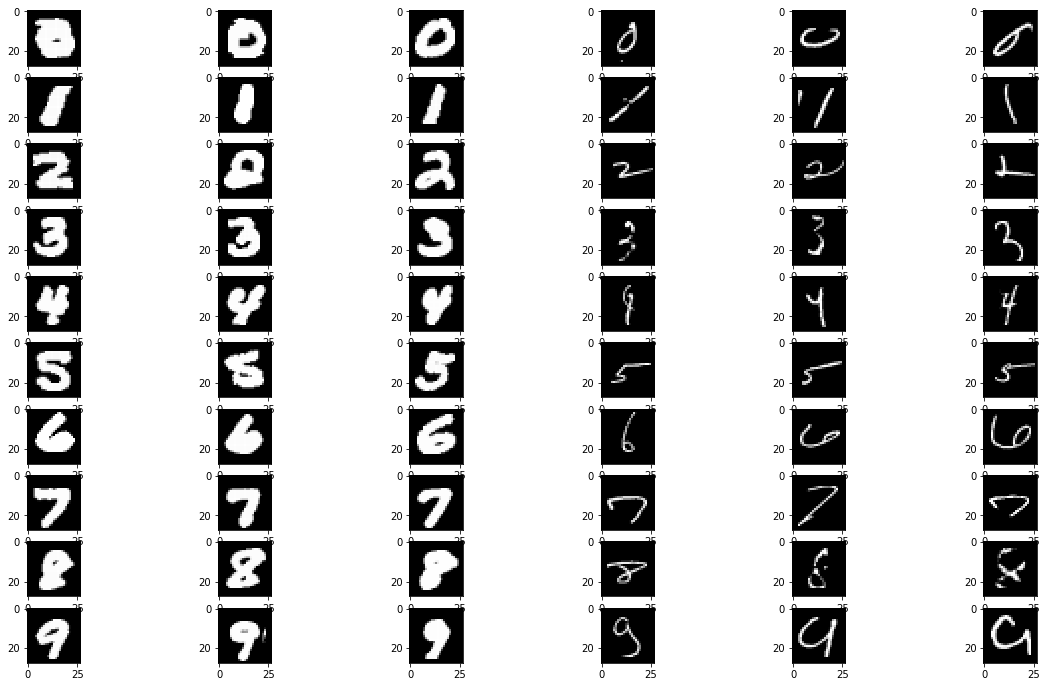

In [37]:
plt.figure(figsize=(10 * 2, 6 * 2))
for digit in range(10):
    min_imgs = list([])
    max_imgs = list([])
    for i in range(len(x_train)):
        if (digit == y_train[i]):
            distance = sum((x_train[i] - average_images[y_train[i]])**2)
            if len(min_imgs) < 3:
                min_imgs.append((distance, i))
                min_imgs.sort()
            if len(max_imgs) < 3:
                max_imgs.append((distance, i))
                max_imgs.sort(reverse=True)
            if len(max_imgs) < 3 or len(min_imgs) < 3:
                continue
            if (distance, i) < min_imgs[-1]:
                min_imgs[-1] = (distance, i)
                min_imgs.sort()
            if (distance, i) > max_imgs[-1]:
                max_imgs[-1] = (distance, i)
                max_imgs.sort(reverse=True)
    for i in range(len(min_imgs)):
        plt.subplot(10, 6, digit * 6 + i + 1)
        plt.imshow(to_img(x_train[min_imgs[i][1]], 28), cmap='gray')
        plt.subplot(10, 6, digit * 6 + i + 1 + 3)
        plt.imshow(to_img(x_train[max_imgs[i][1]], 28), cmap='gray')

## Этап 6. Разобьем выборку на обучающую и тестовую в отношении 7:3.

Назовем данные для обучения x_data и y_data, а выборки для обучения и тестирования x/y_train и x/y_test. В этом нам поможет глубокое копирование.

In [38]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
x_data = deepcopy(x_train)
y_data = deepcopy(y_train)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

## Далее рассмотрим несколько методов реализации.
В каждом методе будем использовать перекрестную 10-кратную валидацию.
N-кратная перекрёстная проверка: данные разбиваются на N частей. На N - 1 частях проводится обучение модели, оставшаяся часть используется для тестирования. Процедура повторяется N раз, в результате чего каждая из N частей данных используется для тестирования.

## Этап 7. Применим метод k ближайших соседей.

Метод заключается в том, что классифицируемый объект относится к тому классу, к которому принадлежат ближайшие k к нему соседей обучающей выборки.

Для каждой из 10 выборок построим графики зависимости ошибки перекрестной проверки на обучающей части и на тестовой части от k.

In [39]:
data = list([])
f = open("train.csv")
isFirst = True
c = 500
for line in f:
    if isFirst == True:
        isFirst = False
        continue
    data.append(list(map(int, line.split(','))))
    if len(data) == c:
        break
f.close()
data = np.array(data)
x_data = data[:, 1:]
y_data = data[:, 0]

500


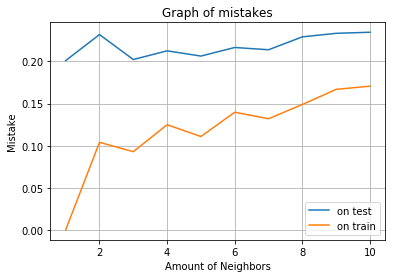

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
print(len(x_data))
x = list([])
y_train = list([])
y_test = list([])
for k in range(1, 10 + 1):
    k_neigh = KNeighborsClassifier(n_neighbors=k)
    cv = cross_validate(k_neigh, x_data, y_data, cv=10, return_train_score=True)
    x.append(k)
    y_train.append(1 - np.array(cv['train_score']).mean())
    y_test.append(1 - np.array(cv['test_score']).mean())

# plt.xlim([1, 10])
# plt.ylim([0.1, 0.2])
plt.title('Graph of mistakes')
plt.plot(x, y_test, label='on test')
plt.plot(x, y_train, label='on train')
plt.ylabel('Mistake')
plt.xlabel('Amount of Neighbors')
plt.legend(loc=4, frameon=True)
plt.grid()
plt.show()

In [41]:
print('Самая маленькая ошибка на тестовой части при k =', y_test.index(min(y_test)) + 1)

Самая маленькая ошибка на тестовой части при k = 1


## Этап 8. Применим метод опорных векторов.

Метод заключается в том, что все исходные вектора переводятся в пространство более высокой размерности и идет поиск разделяющей гиперплоскости. Первоначально строятся две  параллельные гиперплоскости, по обеим сторонам гиперплоскости, разделяющей классы. Разделяющей гиперплоскостью будет гиперплоскость, максимизирующая расстояние до двух параллельных гиперплоскостей. 

Построим график зависимости ошибки перекрестной валидации от параметра С. Параметр С задает настройки метода, регулирующие отношение между максимизацией ширины разделяющей полосы и минимизацией суммарной ошибки.

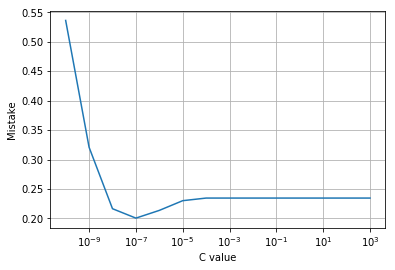

Минимальная ошибка 0.20050919189367966, при c = 1e-07


In [42]:
from sklearn.svm import LinearSVC

y = list([])
for c in range(-10,4):
    svc = LinearSVC(C=10**c)
    scores = cross_val_score(estimator=svc, X=x_data, y=y_data, cv=10)
    y.append(1 - scores.mean())
    
x = list([10**i for i in range(-10, 4)])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x, y)
ax.set_xscale('log')
plt.ylabel('Mistake')
plt.xlabel('C value')
plt.grid()
plt.show()

print('Минимальная ошибка ', min(y),', при c = ', x[y.index(min(y))], sep='')

Построим график зависимости количества опорных векторов, задаваемых гиперплоскостями, от параметра С. 

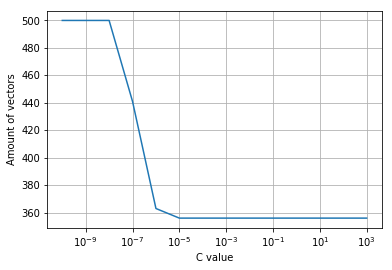

In [43]:
from sklearn.svm import SVC
y = list([])
x = list([])
for c in range(-10,4):
    clf = SVC(kernel='linear', C=10**c).fit(x_data, y_data)
    y.append(clf.support_vectors_.shape[0])
    x.append(10**c)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x, y)
ax.set_xscale('log')
plt.ylabel('Amount of vectors')
plt.xlabel('C value')
plt.grid()
plt.show()

## Этап 9. Применим дерево решений.

Метод заключается в представлении правил в иерархической, последовательной структуре, где каждому объекту соответствует единственный узел, дающий решение. Под правилом понимается логическая конструкция, представленная в виде "если ... то ...".

Построим график зависимости ошибки перекрестной валидации от  параметра max_depth, который соответствует глубине дерева.

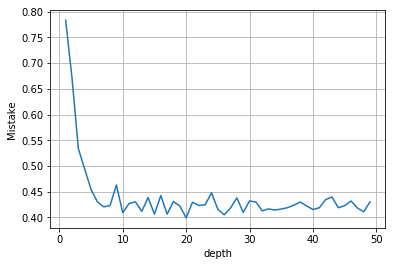

Минимальная ошибка 0.39898850897201354, при max_depth = 20


In [44]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import cross_val_score

y = list([])
x = list([])
for i in range(1, 50):
    clf = DTC(max_depth=i)
    scores = cross_val_score(estimator=clf, X=x_data, y=y_data, cv=10)
    y.append(1 - scores.mean())
    x.append(i)
    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x, y)
plt.ylabel('Mistake')
plt.xlabel('depth')
plt.grid()
plt.show()

print('Минимальная ошибка ', min(y),', при max_depth = ', x[y.index(min(y))], sep='')

Построим график зависимости ошибки перекрестной валидации от параметра min_samples_split, который соответствует минимальному количеству объектов, необходимому для разделения внутреннего узла.

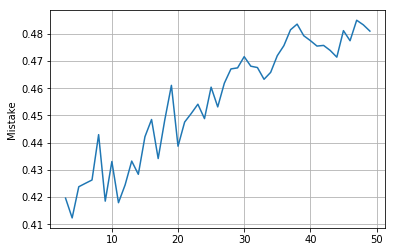

Минимальная ошибка 0.41235017884719627, при min_samples_split = 4


In [45]:
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.model_selection import cross_val_score

y = list([])
x = list([])
for i in range(3, 50):
    clf = DTC(min_samples_split=i)
    scores = cross_val_score(estimator=clf, X=x_data, y=y_data, cv=10)
    y.append(1 - scores.mean())
    x.append(i)
    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line = ax.plot(x, y)
plt.ylabel('Mistake')
plt.grid()
plt.show()

print('Минимальная ошибка ', min(y),', при min_samples_split = ', x[y.index(min(y))], sep='')

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [57]:
model = DTC()
model.fit(x_train, y_train)
model.predict([x_test[9]])
y_test[42]

8

In [58]:
y_test[42]

8